In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
wVb = pd.read_csv('cleanWVb.csv')
wVb.drop('Unnamed: 0', axis = 1, inplace = True)
wVb.head()

name  height  weight  spike  block position
0     Angelina Lazarenko     193      80    320    305   middle
1       Svetlana Serbina     182      71    295    284   setter
2  Ekaterina Shkurikhina     190      72    306    296     wing
3     Kristina Kurnosova     176      62    288    278   libero
4     Ekaterina Novikova     181      70    290    275   setter

#### Assumptions to perform the *t-test*
A *t-test*, is a hypothesis test, that compares two hypothesis (let them be $H_{0}$ , $H_{a}$), and either discards one, or validates both. To do so, both hypothesis must lead to a **normal probability distribution** with the same standard deviation. The calculation of the *t-score* goes as follows:  
$t = \frac{\bar{X} - \mu}{s}\sqrt{n}$  
where $\bar{X}$ is the mean derived from $H_{a}$   
$\mu$ is the population mean derived from $H_{0}$  
$s$ is the standard deviation.    
$n$ is the sample size for the alternative hypothesis.  

In fact, we will be testing the hypothesis by comparing their respective distributions. More precisely, the *t-score* is a measure of how many times $s$ can fit between the two means, scaled by $\sqrt{n}$. Rule of the thumb: the greater the *t-score* the less likely we can consider both distributions compatible. This is a bit tricky, because there are two terms in the formula that contribute to this effect:
- The *z-score* $z = \frac{\bar{X} - \mu}{s}$
- The size of the sample *n* or more accurately, its square root $\sqrt{n}$

The *t-score* will be greater for further apart distributions, but also for greater samples leading to $H_{a}$. For big samples, our *z-score* (how many *s* apart are the distributions), needs to be small enough that scaled by $\sqrt{n}$ stays small. How small? See below. 

![img](normalDifferentArea.png)
*Image taken from https://www.ashokcharan.com/Marketing-Analytics/~st-t-test.php*

In Case I, we have little area under the curve, so it is unlikely that we can validate both hypothesis.  
In Case II we have plenty of area under the curve, so it is more likely that both hypothesis are compatible.    
Notice that even though $\mu - \bar{X}$ is the same for both, the *z-score* is the distance relative to the standard deviation, so it is much greater in Case I.


Let's perform a one tailed *t-test*.  
Once the *t-score* is calculated, we have to shift distributions. We get our value $t$ and locate it in a *t-distribution*, which is similar but not exactly equal to a standard normal distribution (https://en.wikipedia.org/wiki/Student%27s_t-distribution).  
Grapically, we take $t$, and calculate the area under the *t-distribution* that lies further away from 0. Maybe an image is clearer:
![img](t_dist.png)

This area under the curve, is the probability of finding a *t-value* equal or greater, and can be calculated by integration:  
$p = \int \limits _{t} ^ {\infty} T(t) dt$  
Where *t* is our variable and *T* is our distribution function.
This calculation would respond to a hypothesis in the form of:  
- $H_{0}: \mu$
- $H_{a}: \bar{X} > \mu$  

With the probability value *p* calculated, we have to make a decision. That's why we choose a threshold $\alpha$, also called confidence level, to compare with *p*. Typically, $\alpha$ would be 0.01, 0.05 or 0.1, and then we extract the conclusion: Is there enough evidence to suggest we should follow $H_{a}$ instead of $H_{0}$?
- $p > \alpha$ : There is a high probability that, in fact, we can find values of t or greater in the t-distribution, so we should go with $H_{0}: \mu$, and reject $H_{a}$.
- $p < \alpha$ : There is a low probability to find values of t or greater in the distribution, so the null hypothesis $H_{0} : \mu$ is rejected in favour of $H_{a}: \bar{X} > \mu$.

But what does it mean exactly? To put it in plain words, $p>\alpha$ means that the observation and the null hypothesis are compatible, and that $\bar{X}$ is (by our criteria) not much greater than $\mu$. Both distributions are close enough that we have not enough evidence to reject the null hypothesis.  
On the other hand, $p<\alpha$ means we are not likely to find values of t or greater in the t distribution, so both hypothesis are not compatible and in fact, $\bar{X}$ is significantly greater than $\mu$, enough to reject the null hypothesis and go with the observation $H_{a}$. Both distributions are far apart enough to indicate there is evidence to reject the null hypothesis in favour of the observation.

Given $\alpha = 0.05$ what we are really asking is: Is there a 5% chance or more to find our *t-value* or a greater one in the T distribution? For $\alpha = 0.1$ the chance is 10% and for $\alpha = 0.01$ it is one percent.

#### One tailed, two tailed
We introduced a concept called one tailed *t-test*. This responds to alternative hypothesis of the kind:
- $H_{a}: \bar{X}>\mu$
![img](t_dist.png)
$p = \int \limits _{t} ^ {\infty} T(t) dt$

- $H_{a}: \bar{X}<\mu$
![img](t_DistLess.png) 
$p = \int \limits _{-\infty} ^ {t} T(t) dt$

These are called one tailed because we will be only calculating the probability to one side of the *t-value*. However, when we have alternative hypothesis of the kind:
- $H_{a}: \bar{X} \ne \mu$
![img](twoTailed.png)
$p = \int \limits _{-\infty} ^ {-t} T(t) dt + \int \limits _{t} ^ {\infty} T(t) dt$  

This is what is called a two-tailed *t-test*, and takes our value t more as a distance. Basically a two tailed test asks: What is the probability of finding values at a distance t or greater? Again if $p>\alpha$ we should validate the null hypothesis. Otherwise, we should go with the alternate hypothesis.

#### First step: Looking at the distribution and checking it follows a normal function of probability distribution.

In [3]:
def loliChartCount(loliSeries, title, xlabel, ylabel):
    
    fig, ax = plt.subplots(figsize = (15,10))
    
    ax.stem(loliSeries.index, loliSeries, linefmt = '--')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(b = True)
    
    return fig, ax

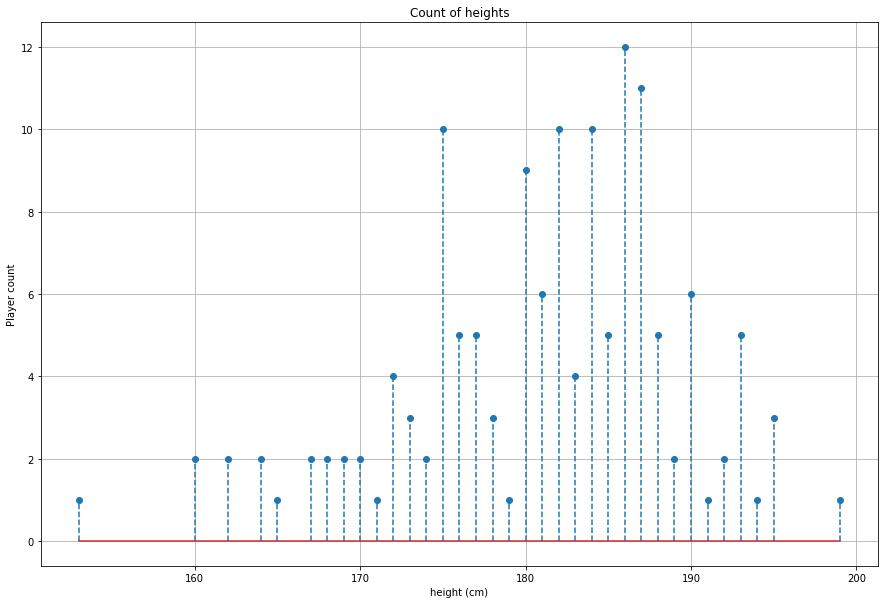

In [4]:
fig,ax = loliChartCount(wVb['height'].value_counts().sort_index(), 'Count of heights',
                       'height (cm)', 'Player count')

However, this is not a probability distribution sample. To do that, normalization is needed. To normalize, we divide each playercount $x_{i}$, by the total number of players n, so we end up with:  
$p(-\infty < X < \infty) = \sum \limits _{i=1} ^ {n} \frac {x_{i}}{n} = 1$  
given that  
$\sum \limits _{i=1} ^ {n} x_{i} = n$  
then:  
$p(X=x_{i}) = \frac{x_{i}}{n}$

In [5]:
def probDensity(series):
    n = series.size
    return series.value_counts().sort_index()/n

def myGaussian(x, mean, std):
    return np.exp(-0.5*((x-mean)/std)**2)/(std*np.sqrt(2*np.pi))

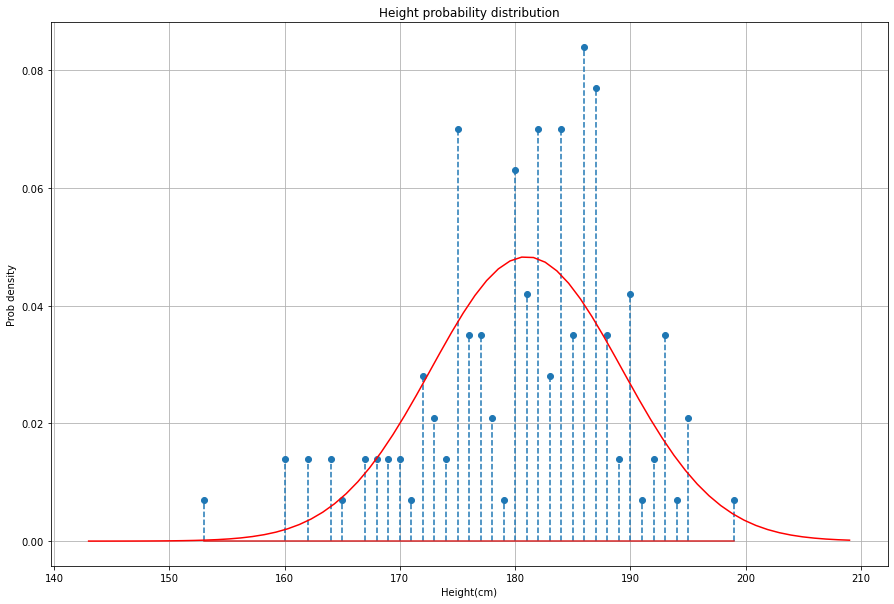

In [6]:
heightDist = probDensity(wVb['height'])

fig, ax = loliChartCount(heightDist, 'Height probability distribution', 'Height(cm)',
                         'Prob density')
x = np.linspace(wVb['height'].min() - 10, wVb['height'].max() + 10, 
                wVb['height'].max()+10-(wVb['height'].min() - 10))
plt.plot(x, myGaussian(x, wVb['height'].mean(), wVb['height'].std()), color = 'red')

Why is the normal distribution 'shorter' than our actual distribution? We are approximating a discrete distribution to a continuous one, which is taking into account the probability of a player's height to be a non-integer number. This comes to a problem of normalization, which can be done to better approximate to a continuous distribution, by generating middle points for example, or applying some algorithm. Nevertheless, this is just for visualization.  
The more our distribution resembles a normal, the more accurate our test will be. In our case, we have a meh similarity. There are parameters to determine resemblance, but to keep it simple and for the sake of this exercise, let's assume the distribution follows a normal function.

### - Exercici 1

Agafa un conjunt de dades de tema esportiu que t'agradi i selecciona un atribut del conjunt de dades. Calcula el p-valor i digues si rebutja la hipòtesi nul·la agafant un alfa de 5%.  

Even though the heights probability distribution is not normal, let's try the t-test for a single variable:    
$H_{0}:$ The average height of the women volleyball players is $\mu=$180 cm. *This is my hypothesis*  
$H_{a}:$ $\bar{X} \neq \mu$     
The average height of the women volleyball player is $\bar{X} = $
{{'{: .3f}'.format(wVb['height'].mean())}}cm. *This is my observation*  
$s =$ {{'{:.3f}'.format(wVb['height'].std())}} cm *For simplicity, let's assume $\sigma$ for $H_{0}$ equal to s*

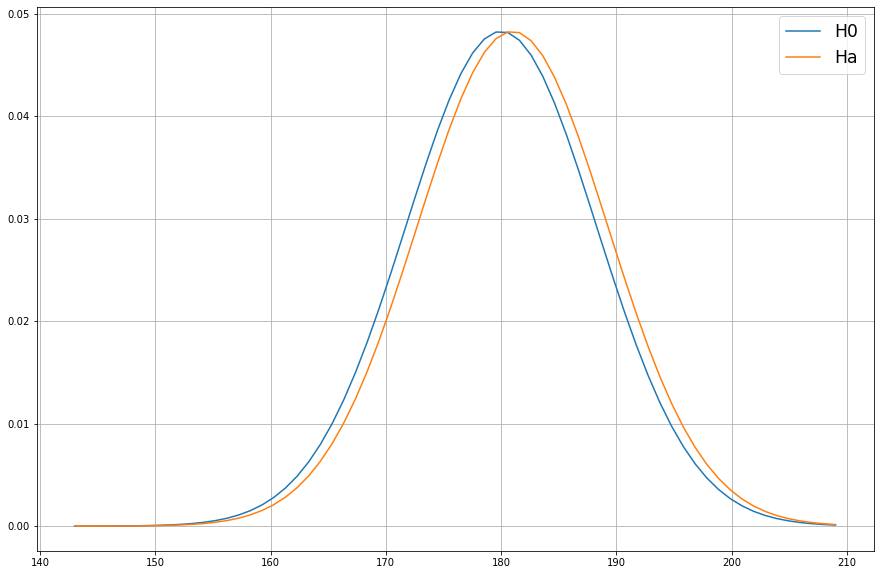

In [7]:
fig, ax = plt.subplots(figsize = (15,10))
x = np.linspace(wVb['height'].min() - 10, wVb['height'].max() + 10, 
                wVb['height'].max()+10-(wVb['height'].min() - 10))
ax.plot(x, myGaussian(x, 180, 8.263), label = 'H0')
ax.plot(x, myGaussian(x, 180.979, 8.263), label = 'Ha')
ax.grid(b=True)
ax.legend(fontsize = 'xx-large')

Just by looking at it, given the sample, I'd say our hypothesis is very likely to be correct. Let's see what the *t-test* has to say

In [8]:
import scipy as sp #fairly easy to use integration method

def verdict(a, p):
    if p > a:
        print('The null hypothesis was correct!')
    else:
        print('The null hypothesis was incorrect!')

In [9]:
#Calculate p value with a method already defined in scipy.stats
h0mean = 180
data = wVb['height']
result = sp.stats.ttest_1samp(data, popmean = h0mean)
alpha = 0.05
verdict(alpha, result.pvalue)

The null hypothesis was correct!


As we were already expecting.